In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# !pip install mpi4py
# !pip install celluloid

In [78]:
%%writefile test.py
from mpi4py import MPI
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import cv2
import tracemalloc


image = cv2.imread('image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

row_block = image.shape[0]//size
img_block = image[rank*row_block:(rank+1)*row_block]

from matplotlib import pyplot as plt
from celluloid import Camera


if rank == 0:
    fig = plt.figure()
    camera = Camera(fig)

tracemalloc.start()
if size == 1:
    for i in range(image.shape[0]):
        shifted_image = np.roll(image, i, axis=0)
        plt.axis('off')
        plt.imshow(shifted_image)
        camera.snap()
else:
    for i in range(image.shape[0]):
        if rank == size-1:
            comm.isend(img_block[-1].shape, dest = 0)
            comm.Send(img_block[-1], dest = 0)
        else:
            comm.isend(img_block[-1].shape, dest = rank+1)
            comm.Send(img_block[-1], dest = rank+1)
        if rank == 0:
            shape = comm.recv(source = size-1)
            data = np.empty(shape, dtype = 'uint8')
            comm.Recv(data, source = size-1)
        else:
            shape = comm.recv(source = rank-1)
            data = np.empty(shape, dtype = 'uint8')
            comm.Recv(data, source = rank-1)

        img_block = np.roll(img_block, 1, axis=0)
        img_block[0] = data.copy()
        block_to_transfer = img_block.copy()

        shifted_image = comm.gather(block_to_transfer, root=0)
        
        if rank == 0:
            shifted_image = np.concatenate(shifted_image, axis=0)
            plt.axis('off')
            plt.imshow(shifted_image)
            camera.snap()
memory = tracemalloc.get_traced_memory()[1]
memory = comm.reduce(memory)
tracemalloc.stop()

if rank == 0:
    animation = camera.animate()
    animation.save(f'shift.gif', writer = 'pillow', fps=20)


end = MPI.Wtime()

if rank==0:
    print(end-start)
    print(memory)

Overwriting test.py


In [79]:
!mpirun --allow-run-as-root -n 1 python test.py

363.1955916670013
192216307


In [80]:
!mpirun --allow-run-as-root -n 2 python test.py

369.54654004500117
194165666


In [81]:
!mpirun --allow-run-as-root -n 3 python test.py

388.7012741109975
194304791


In [82]:
!mpirun --allow-run-as-root -n 4 python test.py

429.0630625070007
194379168


In [83]:
!mpirun --allow-run-as-root -n 5 python test.py

418.4339320029976
194427746


In [84]:
!mpirun --allow-run-as-root -n 6 python test.py

465.95593326000017
194463130


In [85]:
!mpirun --allow-run-as-root -n 7 python test.py

452.3525503160017
192908971


In [86]:
!mpirun --allow-run-as-root -n 8 python test.py

450.3138797920001
194514704


In [87]:
!mpirun --allow-run-as-root -n 9 python test.py

482.98960162300136
194535194


In [88]:
!mpirun --allow-run-as-root -n 10 python test.py

422.80538226799763
194553167


Text(0, 0.5, 'Speedup')

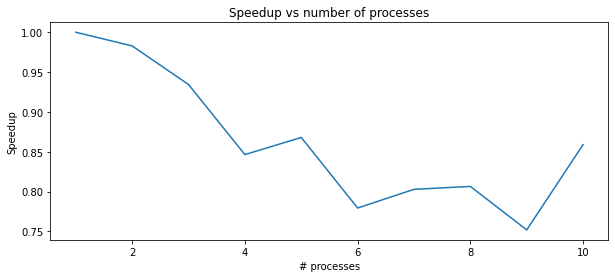

In [89]:
speedup = np.array([363.1955916670013,
                    369.54654004500117,
                    388.7012741109975,
                    429.0630625070007,
                    418.4339320029976,
                    465.95593326000017,
                    452.3525503160017,
                    450.3138797920001,
                    482.98960162300136,
                    422.80538226799763])
speedup = speedup[0] / speedup
plt.figure(figsize=(10,4))
plt.title('Speedup vs number of processes')
plt.plot(np.arange(1,11), speedup)
plt.xlabel('# processes')
plt.ylabel('Speedup')

Text(0, 0.5, 'Memory consumption, bytes')

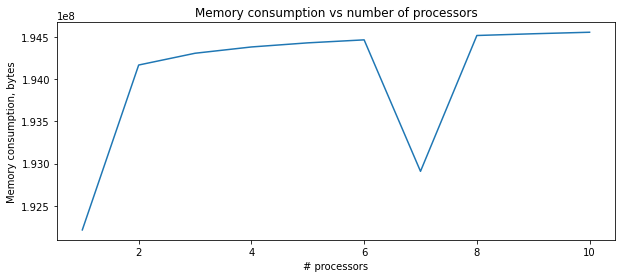

In [90]:
memory = np.array([192216307,
                    194165666,
                    194304791,
                    194379168,
                    194427746,
                    194463130,
                    192908971,
                    194514704,
                    194535194,
                    194553167])
plt.figure(figsize=(10,4))
plt.title('Memory consumption vs number of processors')
plt.plot(np.arange(1,11), memory)
plt.xlabel('# processors')
plt.ylabel('Memory consumption, bytes')